# COURSE: A deep understanding of deep learning
## SECTION: Autoencoders
### LECTURE: Autoencoder with tied weights
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401
##### Modified from original code

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# An aside on Linear vs. Parameter classes

In [9]:
# create an input and weights matrix
x  = torch.rand(10,50)
W1 = nn.Parameter(torch.randn(128,50))

# Let's see what W1 is
print(f'--W1 looks like this--\n{W1}')
print()

# Its size and the size of its transpose
print(f'W1 has the shape: {W1.shape}')
print(f'W1^T has the shape: {W1.t().shape}')
print()

# compute an output
y = x@W1.t()
print(f'x * W1^T has the shape: {y.shape}')

--W1 looks like this--
Parameter containing:
tensor([[-1.1314, -0.9548, -0.4483,  ...,  1.5430, -2.3431,  1.3895],
        [-0.3494, -1.8437, -0.2234,  ...,  0.3110, -0.3552,  0.3475],
        [-0.1349,  0.2531, -0.1665,  ...,  0.2516,  0.4364, -0.1466],
        ...,
        [ 0.3025, -0.5284, -0.5591,  ..., -1.7551,  0.1970, -0.1843],
        [-0.6354, -1.9912,  1.6772,  ..., -0.1734,  0.7086,  1.5789],
        [ 0.4408,  0.9901,  0.5731,  ...,  0.7891, -0.2879,  2.5410]],
       requires_grad=True)

W1 has the shape: torch.Size([128, 50])
W1^T has the shape: torch.Size([50, 128])

x * W1^T has the shape: torch.Size([10, 128])


In [12]:
# Now try again with the Linear method
W2 = nn.Linear(128,50)

# Let's see what W2 is
print(f'--W2 looks like this--\n{W2}')
print()

# Its size and the size of its transpose
print(f'W2 has the shape: {W2.weight.shape}') #can't jus do W2.shape like above
print(f'W2^T has the shape: {W2.weight.t().shape}')
print()

# compute an output
y = x @ (W2.weight)
print(f'x * W2 has the shape: {y.shape}')

--W2 looks like this--
Linear(in_features=128, out_features=50, bias=True)

W2 has the shape: torch.Size([50, 128])
W2^T has the shape: torch.Size([128, 50])

x * W2 has the shape: torch.Size([10, 128])


In [13]:
# confusion from the previous cells
print(W1.shape)
print(W2.weight.shape)

# what causes the confusion
# (size of W -> [outputs,inputs], but nn.Linear expects [inputs,outputs])

torch.Size([128, 50])
torch.Size([50, 128])


In [32]:
# note the inputs vs. how self.weight is created
??nn.Linear.__init__

Signature:
nn.Linear.__init__(
    self,
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring: Initialize internal Module state, shared by both nn.Module and ScriptModule.
Source:   
    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
File:      /opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/linear.py
Type:      function

# Import and process the data

In [33]:
# import dataset
data = np.loadtxt('../11-FFN/mnist_train_small.csv',delimiter=',')

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Create the DL model

In [34]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)
      
      ### encoder layer
      self.enc = nn.Parameter(torch.randn(50,128))
      # self.enc = nn.Linear(128,50) # not used! left here for comparison

      ### latent layer (not used!)
      #self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      # "normal" forward prop in first stage
      x = F.relu( self.input(x) )

      # a Parameter type is not a Linear type, so we implement the multiplication directly
      x = F.relu( x@self.enc.t() ) # can't just do self.enc(x)

      # same for the decoding layer but reversed
      x = F.relu( x@self.enc )

      # "normal" final stage
      y = torch.sigmoid( self.dec(x) )
      return y
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [35]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


# Create a function that trains the model

In [36]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10000
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.0136


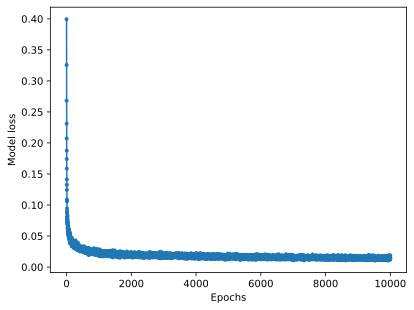

In [37]:
# train the model
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

# Note model is still able to minimize losses with 1 weight matrix missed

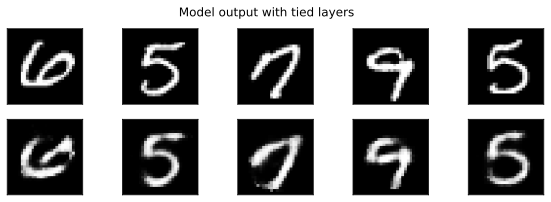

In [39]:
# Visualization of inputs and outputs
X = dataT[:5,:]
yHat = net(X)


# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.suptitle('Model output with tied layers')
plt.show()

# Add noise to see a use case of an autoencoder

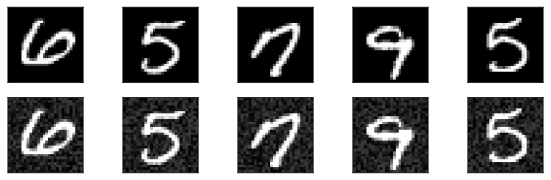

In [40]:
# grab a small set of images
X = dataT[:10,:]

# add noise
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.show()

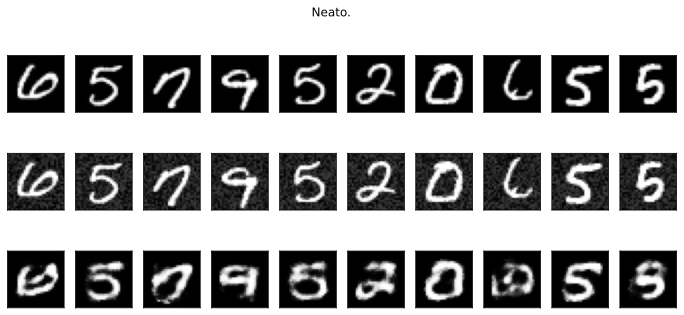

In [41]:
# run through the model
Y = net(Xnoise)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  
plt.suptitle('Neato.')
plt.show()

# Note noice creates additional distortion to the tied-weights model

# Additional explorations

In [ ]:
# 1) The network we built here is not a truly mirrored network: We tied the encoder/decoder layers, but left the input
#    and output layers separate. That's not wrong or bad or anything; it's just a choice. Modify the code to create
#    a truly mirrored network, where all decoding layers are tied to their corresponding encoding layers.
# 
# 2) You don't need to use nn.Parameter; you can still accomplish what we did by using nn.Linear and extracting the
#    weights matrices. Rewrite the code to use nn.Linear instead of nn.Parameter.
# 